# crack 2.17

#### Automate training with Lightning

In [37]:
# !pip install lightning pytorch_lightning

In [38]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import pytorch_lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.tuner import Tuner


torch.manual_seed(2147483647)

In [39]:
names = pd.read_csv("../names.txt",names = ["label"])

In [40]:
all_stoi = {}
all_itos ={}

all = set("".join(names.label+"."))
for index,(chr) in enumerate(sorted(all)):
    all_stoi[chr] = index

for index,(chr) in enumerate(sorted(all)):
    all_itos[index] = chr

In [41]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [42]:
# Model
class MLnames(nn.Module):
  def __init__(self):
    super().__init__()
    # Initialize parameters
    self.c = nn.Parameter(torch.randn(27,2,device =device))
    self.w = nn.Parameter(torch.randn(6,100,device =device))
    self.b = nn.Parameter(torch.randn(100,device =device))
    
    self.w1 = nn.Parameter(torch.randn(100,27,device =device))
    self.b1 = nn.Parameter(torch.randn(27,device =device))

    # self.all_layer = nn.Sequential(
    #   # Input Layer
    #     nn.Linear(6,100),
    #     nn.Tanh(),

    #   # Hidden Layer
    #     nn.Linear(100,100),
    #     nn.Tanh(),

    #   # Output Layer
    #     nn.Linear(100,27)
    # )
    
  # Forward Pass
  def forward(self,x):
    emb = self.c[x] # [32, 3, 2]
    z = torch.tanh(emb.view(-1,self.w.shape[0]) @ self.w + self.b)
    logits = z @ self.w1 + self.b1
    return logits

In [43]:
xo = []
yo = []
blocks = 3

for word in names.label:
    wx = [("."* (blocks - i)) + word  for i in range(blocks)]
    wy = [yo.append(all_stoi[i]) for i in (word+".")]
                       
    for ch1,ch2,ch3 in zip(*wx[:len(wx)]):
        xo.append((all_stoi[ch1],all_stoi[ch2],all_stoi[ch3]))
 
train_x,val_x,train_y,val_y = train_test_split(xo,yo,test_size=0.2,stratify = yo,random_state=42)
val_x,test_x,val_y,test_y = train_test_split(val_x,val_y,test_size=0.1,stratify = val_y, random_state=42)



train_x = torch.tensor(train_x,device = device)
train_y = torch.tensor(train_y,device = device)

val_x = torch.tensor(val_x,device = device)
val_y = torch.tensor(val_y,device = device)

test_x = torch.tensor(test_x,device = device)
test_y = torch.tensor(test_y,device = device)


train_ = {"train_x": train_x, "train_y": train_y}
valid_ = {"val_x": val_x, "val_y": val_y}
test_ = {"test_x": test_x, "test_y": test_y}



print(f"train_x: {len(train_x)} train_y: {len(train_y)}")
print(f"val_x: {len(val_x)} val_y: {len(val_y)}")
print(f"test_x: {len(test_x)} test_y: {len(test_y)}")

# print(len(xo),len(yo))

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x =  self.data[idx]
        y =  self.labels[idx]
        return x,y
        
# # Execute the Data Loading with PyTorch Lightning
class DataModule(L.LightningDataModule):
    def __init__(self, data_dir: str = "../names.txt", batch_size: int = 32):
        super().__init__()
        self.data_dir = pd.read_csv(data_dir,names = ["label"])
        self.batch_size = batch_size

    def setup(self, stage: str = None,train = train_,valid = valid_,test = test_):
        if stage == "fit" or stage is None:
            self.train_ds = CustomDataset(train["train_x"], train["train_y"])
            self.val_ds = CustomDataset(valid["val_x"], valid["val_y"])
        if stage == "validate" or stage is None:
            self.val_ds = CustomDataset(valid["val_x"], valid["val_y"])
        if stage == "test" or stage is None:
            self.test_ds = CustomDataset(test["test_x"], test["test_y"])

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size,shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size,shuffle=True)


train_x: 182516 train_y: 182516
val_x: 41067 val_y: 41067
test_x: 4563 test_y: 4563


In [44]:
# Execute the model with PyTorch Lightning
class LightningModelExe(L.LightningModule):
    def __init__(self,model,lr):
        super().__init__()
        self.model = model
        self.lr = lr

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        x,y = batch
        output = self.forward(x)
        loss = F.cross_entropy(output, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x,y = batch
        output = self.forward(x)
        loss = F.cross_entropy(output, y)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x,y = batch
        output = self.forward(x)
        loss = F.cross_entropy(output, y)
        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.model.parameters(), lr=self.lr)

In [ ]:
if __name__ == "__main__":
    model = MLnames()
    lightning_model = LightningModelExe(model, lr=1.0)
    data_module = DataModule(data_dir="../names.txt", batch_size=64)
    
    trainer = L.Trainer(
    max_epochs=100,
    accelerator="mps",
    devices="auto",
    deterministic=True,
    logger = CSVLogger(save_dir="logs/", name="my-model") # the line with csv export with the CSVLogger instance
    )    

    trainer.fit(lightning_model, datamodule=data_module)
    # trainer.test(lightning_model, datamodule=data_module)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 7.585775750291837e-08
Restoring states from the checkpoint path at /Users/parthmishra/Desktop/Jupyter_files/Makemore_part_2/.lr_find_37af1ffc-90e7-464e-8171-00aa9e6538f7.ckpt
Restored all states from the checkpoint at /Users/parthmishra/Desktop/Jupyter_files/Makemore_part_2/.lr_find_37af1ffc-90e7-464e-8171-00aa9e6538f7.ckpt


_TunerExitException: 

lr.           train_loss_step.    val_loss_step.  val_loss_epoch.   train_loss_epoch    batch.  epoch   
0.01    =>     2.490,              2.310,             2.480,            2.480             64      10       
0.01    =>     2.720,              2.380,             2.360,            2.360             64      100     
0.001    =>    2.790,              2.260,             2.460,            2.460             64      100    




trainer.logger.log_dir:  logs/my-model/version_6


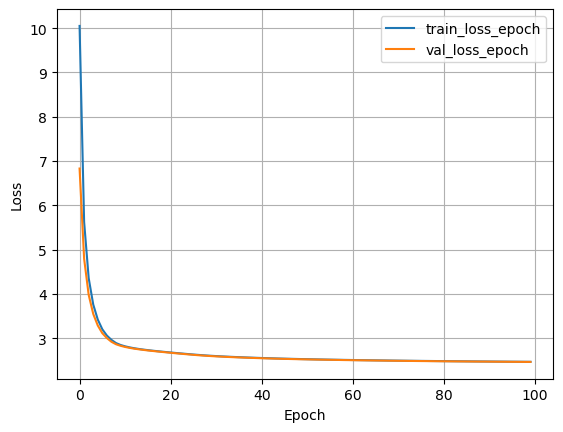

In [46]:
print(f"trainer.logger.log_dir:  {trainer.logger.log_dir}")
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []

agg_col = "epoch"

for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)


df_metrics = pd.DataFrame(aggreg_metrics)

df_metrics [["train_loss_epoch", "val_loss_epoch"]].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss")
    
# df_metrics [["train_acc", "val_acc"]].plot(grid=True, legend=True, xlabel="Epoch", ylabel="ACC")

plt.show()
    
